# SV2TTS Tacotron-2 training

This notebook shows how to create (with *partial transfer learning*), train and use the `SV2TTS` architecture (see the `README` file for more information)

The structure of this notebook is exactly the same as `example_tacotron2`, check it if you want more details on each part ;)

## Imports + model creation

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from models import get_pretrained
from models.tts import SV2TTSTacotron2, WaveGlow
from datasets import get_dataset, train_test_split
from utils import plot_spectrogram, select_embedding, limit_gpu_memory
from utils.text import default_french_encoder
from utils.audio import display_audio, load_audio

gpus = tf.config.list_physical_devices('GPU')

rate = 22050
model_name = 'sv2tts_tacotron2_256_v2_2'

print("Tensorflow version : {}".format(tf.__version__))
print("Available GPU's : {}".format(gpus))

Tensorflow version : 2.10.0
Available GPU's : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# This special cleaner allow to not lowercase the text 
# see my data_processing repository for more examples on text encoding / cleaners
# If you want lowercase, you just have to remove the "cleaners" argument from default_french_encoder()
cleaners = [
    {'name' : 'french_cleaners', 'to_lowercase' : False}
]

encoder = default_french_encoder(vocab_size = 148, cleaners = cleaners)
print(encoder)

config = {
    'nom' : model_name,
    'lang' : 'fr',
    'text_encoder'  : encoder,
    'encoder_name'  : 'audio_encoder_256_mel_lstm',
    'embedding_dim' : 256,
    'use_label_embedding' : False
}

========== Text encoder ==========
Vocab (size = 148) : ['_', '-', '!', "'", '(', ')', ',', '.', ':', ';', '?', ' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
Config : {
  "level": 0,
  "lstrip": false,
  "rstrip": false,
  "cleaners": [
    {
      "name": "french_cleaners",
      "to_lowercase": false
    }
  ],
  "split_pattern": null,
  "bpe_end_of_word": null,
  "pad_token": "",
  "sep_token": null,
  "ukn_token": null,
  "sos_token": "[SOS]",
  "eos_token": "[EOS]",
  "mask_token": null,
  "sub_word_prefix": "",
  "use_sos_and_eos": false
}


In [ ]:
model = SV2TTSTacotron2.from_nvidia_pretrained(** config)
print(model)


In [3]:
model = SV2TTSTacotron2.from_pretrained(pretrained_name = 'tacotron2_siwis', ** config)
print(model)


Model restoration...
Initializing submodel : `tts_model` !
Successfully restored tts_model from pretrained_models/tacotron2_siwis/saving/tts_model.json !
Model tacotron2_siwis initialized successfully !
Initializing model with kwargs : {'tts_model': {'architecture_name': 'tacotron2', 'pad_token': 0, 'vocab_size': 148, 'n_mel_channels': 80, 'init_step': 0, 'encoder_speaker_embedding_dim': 256}}
Initializing submodel : `tts_model` !
Submodel tts_model saved in pretrained_models\sv2tts_tacotron2_256\saving\tts_model.json !
Model sv2tts_tacotron2_256 initialized successfully !
Variables 27 shapes mismatch ((1024, 4096) vs (768, 4096)), making partial transfer
Variables 31 shapes mismatch ((768, 128) vs (512, 128)), making partial transfer
Variables 35 shapes mismatch ((1792, 4096) vs (1536, 4096)), making partial transfer
Variables 38 shapes mismatch ((1792, 80) vs (1536, 80)), making partial transfer
Variables 40 shapes mismatch ((1792, 1) vs (1536, 1)), making partial transfer
Weights tr

In [ ]:
pretrained_name = 'sv2tts_tacotron2_256'

model = SV2TTSTacotron2.from_pretrained(
    pretrained_name = pretrained_name, ** config
)
print(model)


## Model initialization + dataset loading

In [2]:
model = get_pretrained(model_name)

lr = { 'name': 'WarmupScheduler', 'maxval' : 75e-5, 'minval' : 25e-5, 'factor' : 1024, 'warmup_steps' : 2048}
lr = 5e-4

model.compile(
    optimizer = 'adam', optimizer_config = {'lr' : lr}
)

print(model)

Model restoration...
Initializing submodel : `tts_model` !
Optimizer 'tts_model_optimizer' initilized successfully !
Successfully restored tts_model from pretrained_models/sv2tts_tacotron2_256_v2_2/saving/tts_model.json !
[WARNING] Some layers have not bene restored from the checkpoint ! Run `model.load_checkpoint().assert_consumed()` to check if it is a critical error or not
Model sv2tts_tacotron2_256_v2_2 initialized successfully !
Model tts_model is already compiled !

========== sv2tts_tacotron2_256_v2_2 ==========
Sub model tts_model
- Inputs 	: unknown
- Outputs 	: unknown
- Number of layers 	: 3
- Number of parameters 	: 30.341 Millions
- Optimizer 	: {'name': 'RMSprop', 'learning_rate': {'class_name': 'DivideByStep', 'config': {'factor': <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, 'minval': <tf.Tensor: shape=(), dtype=float32, numpy=0.00025>, 'maxval': <tf.Tensor: shape=(), dtype=float32, numpy=0.00075>}}, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon'

In [5]:
kwargs = {
    'embedding_dim'  : model.embedding_dim,
    'embedding_name' : model.encoder_name
}

datasets = ['siwis', 'voxforge', 'common_voice']
datasets = ['siwis', 'voxforge']

dataset = get_dataset(
    datasets, accent = 'france', shuffle = True, ** kwargs
)
# If the dataset is a dict, it is typically a STT dataset where
# validation set contains "new speakers" but it is not relevant for this model
# because generalization to new speakers is really hard and only interesting if datasets
# have many speakers (>> 1k) (which is really rare in TTS datasets)
if isinstance(dataset, dict): dataset = dataset['train']
#dataset = filter_dataset(dataset, duree = lambda d: d < 11)

print("Dataset length : {} ({} speakers)".format(
    len(dataset), len(dataset['id'].unique())
))


Loading dataset siwis...
Loading dataset voxforge...
Dataset length : 32432 (2258 speakers)


The model requires `text`, `filename` and `embedding` (or `speaker_embedding`) columns. The `wavs_22050` allows to directly load resampled audio (which speeds up training). 

In [6]:
dataset.head()

,text,filename,wavs_16000,wavs_22050,id,embedding,speaker_embedding,time,dataset_name
22592,Elles dérobent le génie De leurs mollets sous ...,D:/datasets/VoxForge/fr/ThinkroSystem-20130909...,D:/datasets/VoxForge\fr\ThinkroSystem-20130909...,D:/datasets/VoxForge\fr\ThinkroSystem-20130909...,ThinkroSystem-20130909-ohz,"[-6.6477132e-06, 2.300845e-05, -3.556684e-06, ...","[-4.1663825e-06, 1.6285456e-05, -1.5146153e-06...",-1.0,VoxForge
21084,C’est là où le peuple des mers vient se remont...,D:/datasets/VoxForge/fr/luxurien-20140916-axi/...,D:/datasets/VoxForge\fr\luxurien-20140916-axi\...,D:/datasets/VoxForge\fr\luxurien-20140916-axi\...,luxurien-20140916-axi,"[2.0653886e-06, 0.00014578477, 0.0011611554, -...","[1.5238817e-05, -6.1733554e-06, 0.0009603618, ...",-1.0,VoxForge
17401,"Après deux heures et demie de descente, ils at...",D:/datasets/VoxForge/fr/JulienFlajollet-201111...,D:/datasets/VoxForge\fr\JulienFlajollet-201111...,D:/datasets/VoxForge\fr\JulienFlajollet-201111...,JulienFlajollet-20111127-gef,"[-1.2153155e-06, -7.171757e-06, 8.789301e-05, ...","[7.8305426e-08, 1.701442e-05, 0.0001244416, -1...",-1.0,VoxForge
24603,"Certains, malgré leur ancienneté en français, ...",D:/datasets/VoxForge/fr/Mariane-20090910-pvf/w...,D:/datasets/VoxForge\fr\Mariane-20090910-pvf\w...,D:/datasets/VoxForge\fr\Mariane-20090910-pvf\w...,Mariane-20090910-pvf,"[1.2937538e-06, -0.0006881901, 8.857657e-05, -...","[-5.361458e-07, -0.00028032923, 6.740652e-05, ...",-1.0,VoxForge
731,Ce n’est pas un geste anodin.,D:/datasets/SIWIS/fr/wavs/part1/neut_parl_s04_...,D:/datasets/SIWIS\fr\wavs_16000\part1\neut_par...,D:/datasets/SIWIS\fr\wavs_22050\part1\neut_par...,siwis,"[-9.350708e-06, 4.624893e-05, -2.1542333e-05, ...","[-3.8699536e-06, 7.383372e-05, -1.0864748e-05,...",-1.0,siwis


## Training

In [ ]:
epochs          = 5
batch_size      = 32
valid_batch_size    = batch_size

max_valid_size  = min(int(0.1 * len(dataset)), 256 * valid_batch_size)

train_size      = min(1024 * batch_size, len(dataset) - max_valid_size)
valid_size      = min(len(dataset) - train_size, max_valid_size)

shuffle_size    = batch_size * 16
pred_step       = -1

""" Custom training hparams """
augment_prct        = 0.25
augment_embedding   = False

trim_audio      = True
reduce_noise    = True if 'common_voice' in datasets else False
trim_threshold  = 0.075
max_silence     = 0.1
trim_method     = 'window'
trim_mode       = 'start_end'

trim_mel     = False
trim_factor  = 0.6
trim_mel_method  = 'max_start_end'

# Seems to be interesting for single-speaker fine-tuning
# and for a better generalization but seems to slow down convergence 
use_label_embedding = False

max_input_length = 75
max_output_length = 512

""" Training """

dataset = dataset[dataset['text'].apply(lambda t: len(t) < max_input_length)]
train, valid = train_test_split(
    dataset, train_size = train_size, valid_size = valid_size, shuffle = True
)

print("Training samples   : {} - {} batches - {} speakers".format(
    len(train), len(train) // batch_size, len(train['id'].unique())
))
print("Validation samples : {} - {} batches - {} speakers".format(
    len(valid), len(valid) // valid_batch_size, len(valid['id'].unique())
))

# This feature seems interesting for singl-speaker fine-tuning
# If you want to enable it, put `trainable = False`
trainable = False
if model.epochs >= 5:
    model.tts_model.postnet.trainable = trainable
if model.epochs >= 10:
    model.tts_model.encoder.trainable = trainable

model.train(
    train, validation_data = valid, 
    epochs = epochs, batch_size = batch_size, valid_batch_size = valid_batch_size,

    max_input_length = max_input_length, max_output_length = max_output_length,
    shuffle_size = shuffle_size, pred_step = pred_step,
    augment_prct = augment_prct, augment_embedding = augment_embedding,
    
    trim_audio = trim_audio, reduce_noise = reduce_noise, trim_threshold = trim_threshold,
    max_silence = max_silence, trim_method = trim_method, trim_mode = trim_mode,
    
    trim_mel = trim_mel, trim_factor = trim_factor, trim_mel_method = trim_mel_method,
    
    use_label_embedding = use_label_embedding
)



In [ ]:
model.plot_history()
print(model.history)

## Prediction / inference

### Prediction with target

This cell allows you to make prediction **with** target : it means the model will perform an inference and a prediction (as during training)

Next you can make the `waveglow inference` with the section related to `prediction on training generated` (you just have to replace `mode = 'train'` by `mode = 'pred'`)

In [ ]:
config = model.get_dataset_config(batch_size = 1, cache = False, is_validation = True)

sub_ds = valid.sample(15, random_state = 1024)
ds     = prepare_dataset(sub_ds, ** config)

for i, batch in enumerate(ds):
    model.predict_with_target(
        batch, step = 'test', prefix = 'pred_{}'.format(i),
        directory = model.pred_dir, show = True
    )


### Prediction without target

This cell performs an inference **without** target (i.e. by setting the text you want) !

The first cell is only required if you have never trained your model as the model does not have any *default embedding* at its initialization. If you explicitely gives an `embedding` (with the `embeddings` parameter), this cell is also not required.

In [4]:
kwargs = {
    'embedding_name' : model.encoder_name
}

datasets = 'siwis'

dataset = get_dataset(datasets, ** kwargs)

embeddings = dataset.sample(10)
#model.set_default_embeddings(embeddings)

Loading dataset siwis...


In [ ]:
text = "Bonjour le monde !"

model.predict(text, overwrite = True, save = True)

## Complete inference

These cells performs a complete inference (i.e. with the `vocoder` part). 

Note that if you want to use `PtWaveGlow` instead of `WaveGlow`, it is required to restart your kernel, then execute the 1st cell (imports), and finally the cells below. You **must** first instanciate the `PtWaveGlow` model, which internally calls `limit_gpu_memory`, to reduce the visible GPU memory for `tensorflow` (to ensure the coexistance of both libraries). 

In [6]:
waveglow = WaveGlow() #PtWaveGlow()
model    = get_pretrained(model_name)

Model restoration...
Initializing submodel : `vocoder` !
Successfully restored vocoder from pretrained_models/WaveGlow/saving/vocoder.json !
[WARNING] Some layers have not bene restored from the checkpoint ! Run `model.load_checkpoint().assert_consumed()` to check if it is a critical error or not
Model WaveGlow initialized successfully !


In [7]:
kwargs = {
    'embedding_name' : model.encoder_name
}

datasets = ['siwis', 'voxforge']

dataset = get_dataset(
    datasets, accent = 'france', shuffle = True, ** kwargs
)

Loading dataset siwis...
Loading dataset voxforge...


In [ ]:
text = "Bonjour tout le monde ! Voici une démonstration du modèle en français."

# Select an embedding and display original speaker audio associated to this embedding
x = random.randrange(0, len(dataset))
display_audio(dataset.at[x, 'filename'])

embedding = select_embedding(dataset, mode = x)

silence = np.zeros((int(rate * 0.15),))
audios = []
if not isinstance(text, list): text = [text]

model.predict(text, embeddings = dataset, mode = x, vocoder = waveglow, save = False, display = True)

## Waveglow inference on training generated audios

This is a demonstration on prediction at step 500 so it is normal that inference is so bad ;)

In [ ]:
def infer_with_target(model_name, step, n, mode, save = False, display = True):
    if mode == 'train':
        directory = os.path.join('pretrained_models', model_name, 'training-logs', 'eval', 'mels')
        filename = 'pred_step-{:06d}_{}_target.npy'.format(step, n)
        pred_filename = 'pred_step-{:06d}_{}_pred.npy'.format(step, n)
        infer_filename = 'pred_step-{:06d}_{}_infer.npy'.format(step, n)
    else:
        directory = os.path.join('pretrained_models', model_name, 'outputs', 'mels')
        filename = 'pred_{}_target.npy'.format(n)
        pred_filename = 'pred_{}_pred.npy'.format(n)
        infer_filename = 'pred_{}_infer.npy'.format(n)

    if not os.path.exists(os.path.join(directory, filename)): return
    
    target = np.load(os.path.join(directory, filename))
    pred   = np.load(os.path.join(directory, pred_filename))
    infer  = np.load(os.path.join(directory, infer_filename))
    
    audio       = waveglow.infer(target)
    audio_pred  = waveglow.infer(pred)
    audio_infer = waveglow.infer(infer)

    _ = display_audio(audio, rate = rate)
    _ = display_audio(audio_pred, rate = rate)
    _ = display_audio(audio_infer, rate = rate)
    
    if save:
        save_dir = directory.replace('mels', 'audios')
        os.makedirs(save_dir, exist_ok = True)
        write_audio(audio, os.path.join(save_dir, filename[:-3] + 'mp3'), rate = rate)
        write_audio(audio_pred, os.path.join(save_dir, pred_filename[:-3] + 'mp3'), rate = rate)
        write_audio(audio_infer, os.path.join(save_dir, infer_filename[:-3] + 'mp3'), rate = rate)
    
    plot_spectrogram(
        target = target, prediction = pred, inference = infer
    )


In [ ]:
step, mode = 500, 'train'

for n in range(5):
    infer_with_target(model_name, step, n, mode)


## Tests

{'factor': 1024.0, 'warmup_steps': 2048, 'minval': 0.00025, 'maxval': 0.00075}


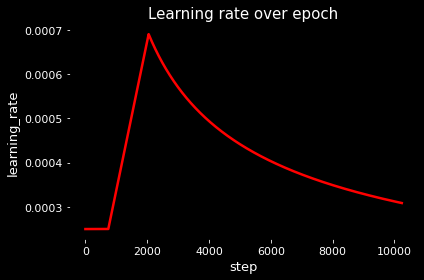

In [7]:
from custom_train_objects.optimizers import WarmupScheduler

lr = WarmupScheduler(maxval = 75e-5, minval = 25e-5, factor = 1024)
print(lr.get_config())
lr.plot(1024 * 10)